# k-means clustering
k-means clustering is an unsupervised machine learning model. It clusters observations into k partitions.

## The algorithm

The algorithm has two steps and an initialization procedure.

### Initialization

Generate k random points in the sample space or choose k random observations as the inital centroids.

### Assignment

Assign each observation to the nearest centroid.

### Update

Move each centroid to the mean of the observations assigned to it.

### Convergence

The algorithm converges when no new assignments are made in an iteration.

In [30]:
import numpy as np

def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    """Euclidean distance between two vectors.
    
    Args:
        a: First vector.
        b: Second vector.
    
    Returns:
        Euclidean distance between a and b.
    """
    return np.sqrt(np.sum(np.square(a - b)))

def k_means(k: int, data: np.ndarray) ->tuple[np.ndarray, np.ndarray]:
    """K-means clustering algorithm.
    
    Args:
        k: Number of clusters.
        data: Data to cluster.
    
    Returns:
        Cluster assignments for each data point and cluster centroids.
    """
    # Initialize centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
    
    # Initialize assignments
    assignments = np.zeros(data.shape[0], dtype=np.int32)
    
    # Iterate until convergence
    while True:
        # Assign data points to centroids
        for i in range(data.shape[0]):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = euclidean_distance(data[i, :], centroids[j, :])
            assignments[i] = np.argmin(distances).astype(int)
        
        # Update centroids
        new_centroids = []
        for j in range(k):
            # Check if cluster is empty
            if np.sum(assignments == j) == 0:
                new_centroids.append(centroids[j, :])
            else:
                new_centroids.append(np.mean(data[assignments == j, :], axis=0))
        new_centroids = np.array(new_centroids)

        # Check convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids 
    
    return assignments, centroids

## Testing

The distortion is a method of determining the quality of fit. It measures the sum of the squared distances between observations and their centroids. By it's nature the k-means algorithm monotonically decreases the distortion values of it's assignments each iteration until convergence.

In [2]:
def distortion(data: np.ndarray, assignments: np.ndarray, centroids: np.ndarray) -> float:
    """Compute distortion.
    
    Args:
        data: Data to cluster.
        assignments: Cluster assignments.
        centroids: Cluster centroids.
    
    Returns:
        Distortion.
    """
    distortion = 0
    for i in range(data.shape[0]):
        distortion += euclidean_distance(data[i, :], centroids[int(assignments[i]), :])
    return distortion/data.shape[0]

In [3]:
def generate_data(n: int, k: int, var: float = 1, dis: float = 10, d: int = 2) -> np.ndarray:
    """Generate data in k clusters as a normal distribution centered around a random point.
    
    Args:
        n: Number of data points per cluster.
        k: Number of clusters.
        var: Variance of the normal distribution.
        dis: Scale of distance between clusters.
        d: Number of dimensions.
    
    Returns:
        Data.
    """
    data = np.zeros((n * k, d))
    for i in range(k):
        mu = np.random.uniform(-1, 1, d) * dis
        data[i * n:(i + 1) * n, :] = np.random.normal(mu, var, (n, d))
    return data

## Visualizing the results

### Non-optimality

In some runs the algorithm can converge on clearly un-optimal clusters. This is because, even though the distortion is monotonically decreasing, the algorithm can become stuck in local optimums.

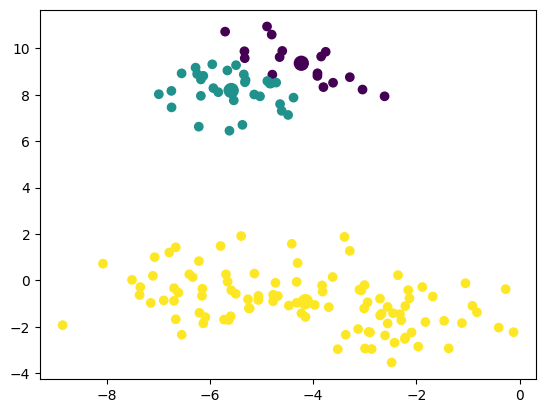

In [45]:
from matplotlib import pyplot as plt

def plot_data(data: np.ndarray, assignments: np.ndarray, centroids: np.ndarray) -> None:
    """Plot data.
    
    Args:
        data: Data to plot.
        assignments: Cluster assignments.
        centroids: Cluster centroids.

    Raises:
        ValueError: If data is not 2D or 3D.
    """
    # Plot 2D data
    if data.shape[1] == 2:
        plt.scatter(data[:, 0], data[:, 1], c=assignments)
        plt.scatter(centroids[:, 0], centroids[:, 1], c=range(len(centroids)), s=100)
        plt.show()
    # Plot 3D data
    elif data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=assignments)
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c=range(len(centroids)), s=100)
        plt.show()
    else:
        raise ValueError('Data must be 2D or 3D.')

# Generate data
data = generate_data(50, 3)

# Cluster data
assignments, centroids = k_means(3, data)

# Plot data
plot_data(data, assignments, centroids)


## Improvements

Various techniques can produce better fits.

### Best of multiple trials

Starting with roughtly correct inital centroids will mean the algorithm conveges to a globally optimal result. If several trials are run and the best is picked, it's much less likely that the optimal result is missed.

Run this trial a few times and try to find an unoptimal result.

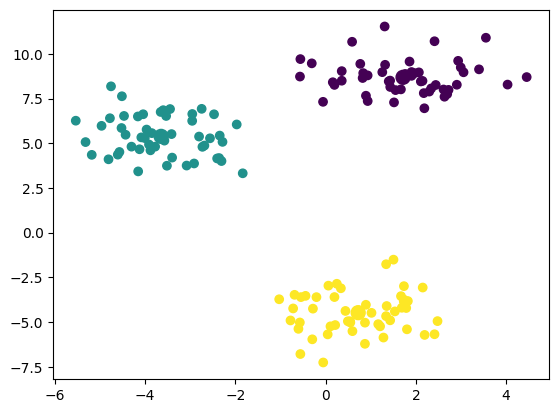

In [5]:
def best_of_n(k: int, data: np.ndarray, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Run k-means n times and return the best result.
    
    Args:
        k: Number of clusters.
        data: Data to cluster.
        n: Number of times to run k-means.
    
    Returns:
        Cluster assignments and cluster centroids.
    """
    best_assignments = None
    best_centroids = None
    best_distortion = np.inf
    for i in range(n):
        assignments, centroids = k_means(k, data)
        d = distortion(data, assignments, centroids)
        if d < best_distortion:
            best_assignments = assignments
            best_centroids = centroids
            best_distortion = d
    return best_assignments, best_centroids

# Generate data
data = generate_data(50, 3)

# Run k-means 10 times and plot the best result
assignments, centroids = best_of_n(3, data, 10)

# Plot data
plot_data(data, assignments, centroids)

### k estimation

For some data the number of clusters is unknown and must be estimated. If k is too low distortion values will usually be quite high. If k is too high the model can begin to overfit. 

#### Elbow Method

The elbow method of finding k is two take the distortion in a range and chose the k at the inflection point. This is usually where the number of clusters is correct and adding more grants diminishing returns.

As you can see in this there is a significant inflection point at the correct number of clusters. This method can work well for well clustered data but if the data is more continuous the curve can be smoother. 

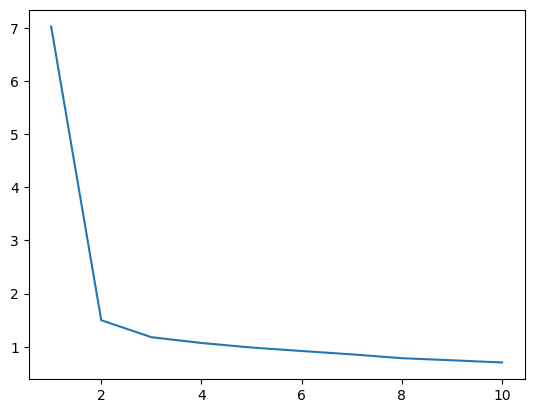

In [6]:
# Generate data
data = generate_data(50, 3)

# Plot distortion vs. k
max_k = 10
distortions = []
for k in range(1, max_k + 1):
    assignments, centroids = best_of_n(k, data, 10)
    distortions.append(distortion(data, assignments, centroids))
plt.plot(range(1, max_k + 1), distortions)
plt.show()

#### Silhouette Analysis

The Silhouette analysis is a method to estimate the number of clusters in a dataset. It is generally more robust than the elbow method and removes the need to judge an inflection point in discrete data. Silhouette analysis uses the equation $s\left(o\right)=\frac{b\left(o\right)-a\left(o\right)}{\max\left(a\left(o\right),\ b\left(o\right)\right)}$ where $a\left(o\right)$ is the average distance of a point to all others in it's cluster and $b\left(o\right)$ is the minimum average distance to the points in other clusters.

Points with a high silhouette score are likely clustered very well because they are close to their neighbors and far from others. To select a k, chose the value that gives the highest mean silhouette score. The process is not garanteed to be perfect but is generally less ambigous than the elbow method.

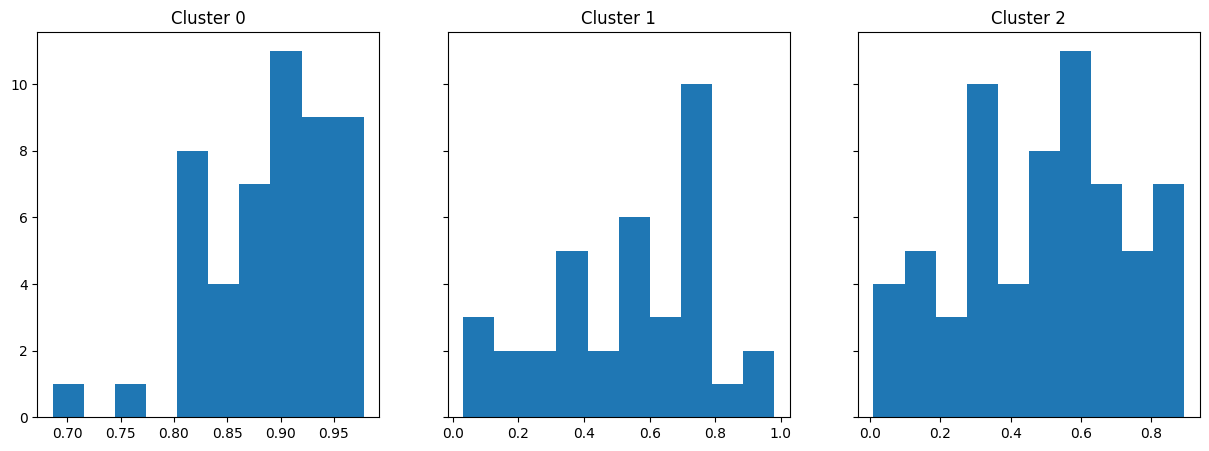

In [7]:
def silhouette(data: np.ndarray, assignments: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """Compute the silhouette score of a clustering.
    
    Args:
        data: Data to cluster.
        assignments: Cluster assignments.
        centroids: Cluster centroids.
    
    Returns:
        Silhouette scores of each point.
    """
    silhouette = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        # Compute the average distance to the points in the same cluster
        a = euclidean_distance(data[i, :], centroids[int(assignments[i]), :])
        # Compute the minimum average distance to the points in other clusters
        b = np.inf
        for j in range(centroids.shape[0]):
            if j != assignments[i]:
                b = min(b, euclidean_distance(data[i, :], centroids[j, :]))
        # Compute the silhouette score
        silhouette[i] = (b - a) / max(a, b)
    return silhouette

# Generate data
data = generate_data(50, 3)

# Run k-means 10 times and plot the best result
assignments, centroids = best_of_n(3, data, 10)

# Plot silhouette scores of the points in each cluster
fig, axes = plt.subplots(1, centroids.shape[0], figsize=(15, 5), sharey=True)
for i in range(centroids.shape[0]):
    axes[i].hist(silhouette(data, assignments, centroids)[assignments == i])
    axes[i].set_title(f'Cluster {i}')
plt.show()

Estimated number of clusters: 3


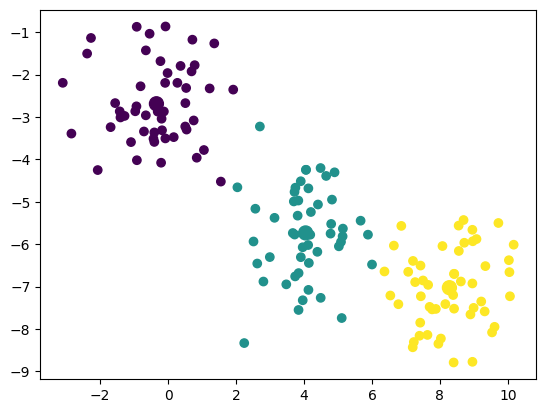

In [8]:
def estimate_k(data: np.ndarray, max_k: int = 10) -> int:
    """Estimate the number of clusters in the data using the silhouette score.
    
    Args:
        data: Data to cluster.
        max_k: Maximum number of clusters to consider.
    
    Returns:
        Estimated number of clusters.
    """
    best_k = 1
    best_silhouette = -np.inf
    for k in range(2, max_k + 1):
        assignments, centroids = best_of_n(k, data, 10)
        s = np.mean(silhouette(data, assignments, centroids))
        if s > best_silhouette:
            best_k = k
            best_silhouette = s
    return best_k

# Generate data
data = generate_data(50, 3)

# Estimate the number of clusters
k = estimate_k(data)
print(f'Estimated number of clusters: {k}')

# Run k-means 10 times and plot the best result
assignments, centroids = best_of_n(k, data, 10)

# Plot data
plot_data(data, assignments, centroids)

## Demonstrations

## Seaborn iris flowers

The iris dataset classifies flowers off of physical features. Silhouette analysis predicts only two clusters while there are three in reality. This goes to show that models cannot be trusted absolutly. Regardless, the results still show logical clustering.

Estimated number of clusters: 2


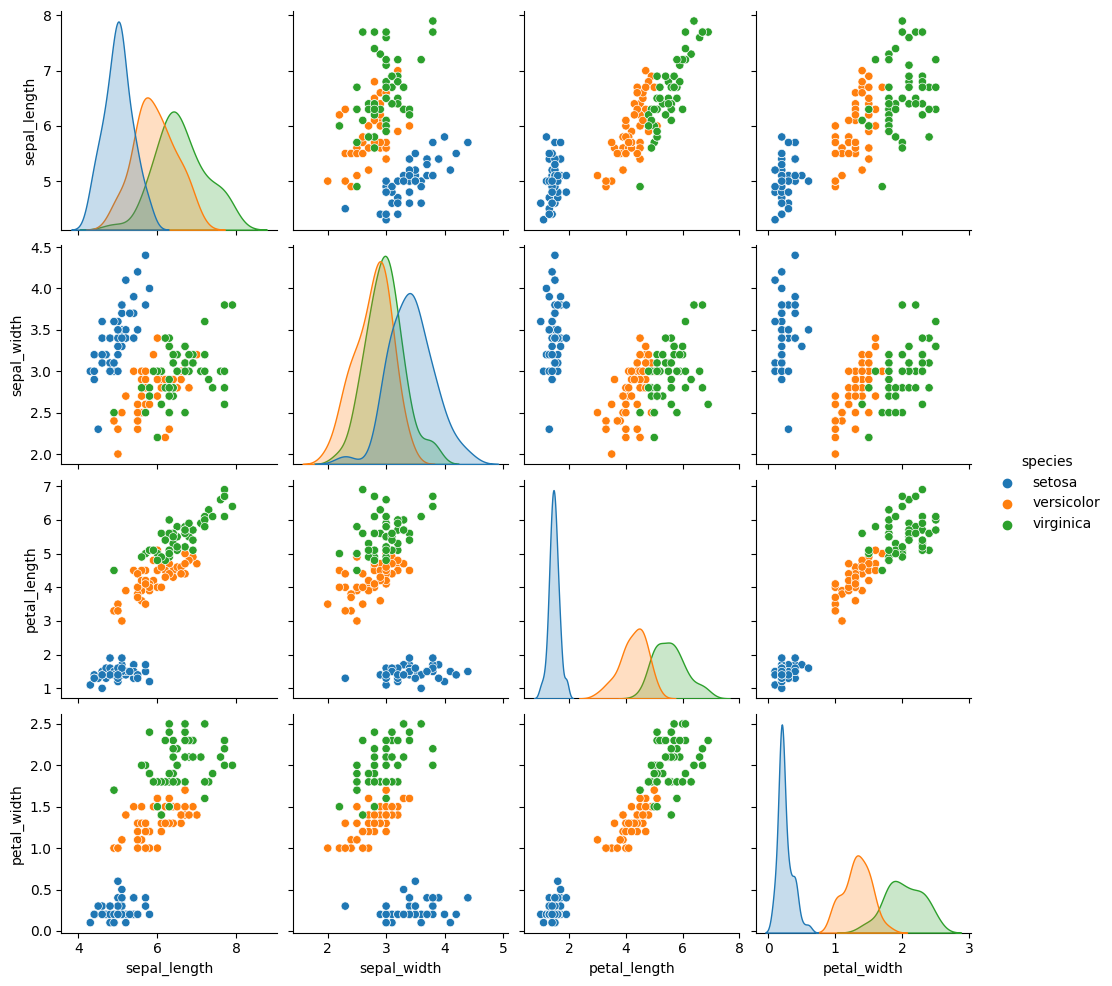

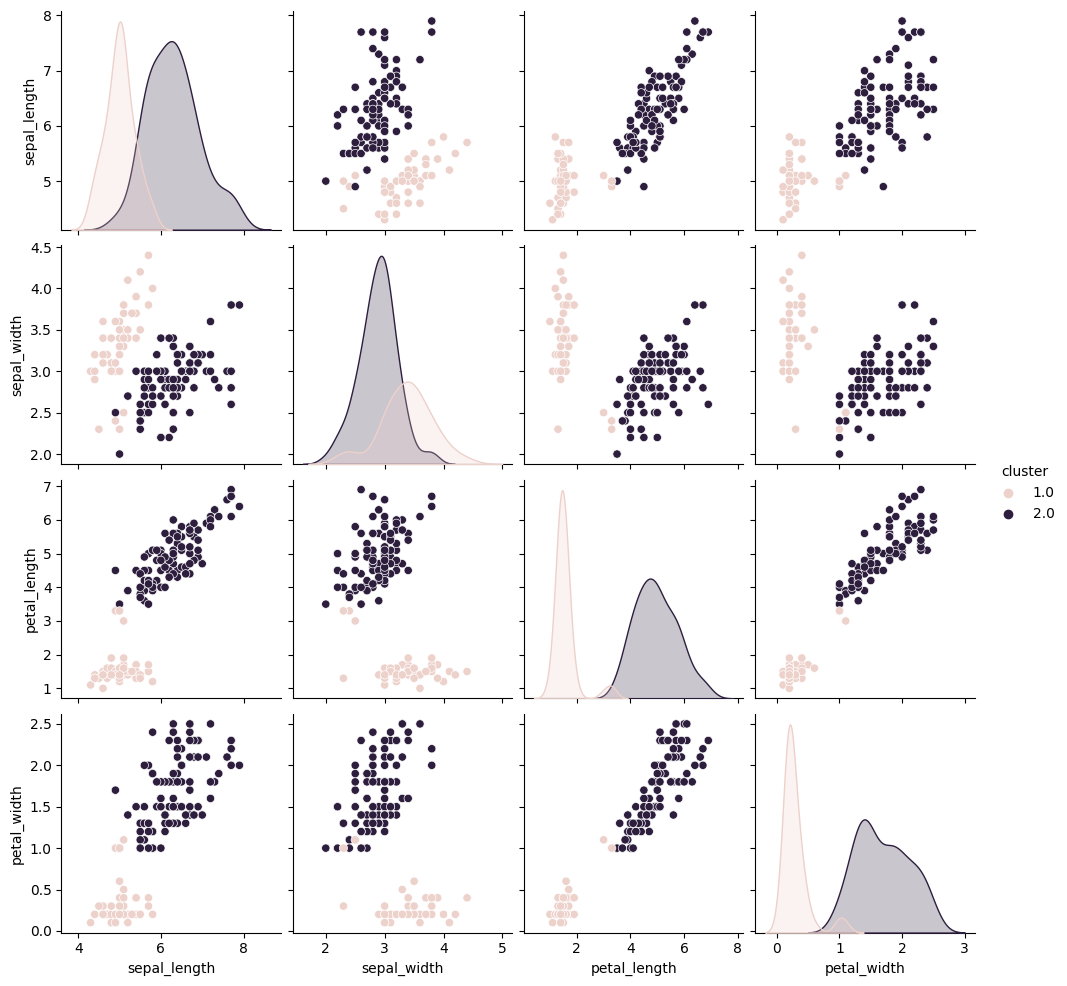

In [9]:
import pandas as pd
import seaborn as sns

# Load the sample data
df = sns.load_dataset('iris')
sns.pairplot(df, hue='species', vars=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

# Convert the data to a NumPy array
np_data = df.to_numpy()
data, labels = np_data[:, :-1], np_data[:, -1]

# Estimate the number of clusters
k = estimate_k(data, max_k=10)
print(f'Estimated number of clusters: {k}')

# Run k-means
assignments, centroids = best_of_n(k, data, 10)
df.loc[:, 'cluster'] = assignments+1

# Plot data
sns.pairplot(df, hue='cluster')


## Handwritten digits

Any set of points can be clustered. The mnist dataset can be represented as a set of vectors in $8*8$ space. The centroids should exist at the center of each cluster.

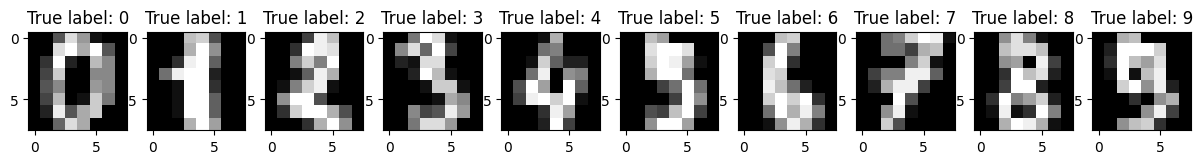

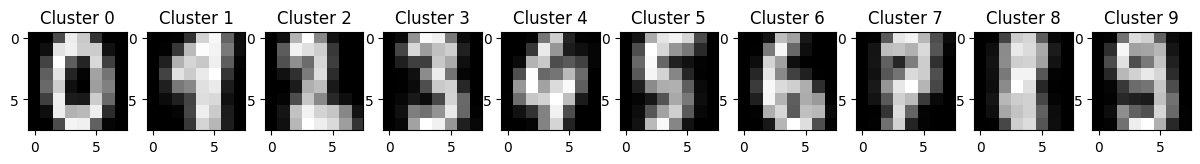

In [40]:
from sklearn.datasets import load_digits

# Load the sample data
digits = load_digits()

# Plot the first 10 digits
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f'True label: {digits.target[i]}')
plt.show()

# Convert the data to a NumPy array
data = digits.images

# Run k-means
k = 10
assignments, centroids = best_of_n(k, data, 10)

# Find the most common label in each cluster
labels = np.zeros(k)
for i in range(k):
    labels[i] = np.bincount(digits.target[assignments == i]).argmax()

# Sort the centroids and labels by their labels
sorted_centroids = centroids[np.argsort(labels)]

# Plot centroids
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axes[i].imshow(sorted_centroids[i], cmap='gray')
    axes[i].set_title(f'Cluster {i}')
plt.show()
